<a href="https://colab.research.google.com/github/AnastasiaBrinati/esercizi-PMCSN-23-24/blob/main/esercizio_feedback_simulazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESERCIZIO SSQ CON FEEDBACK

####imports

In [1]:
pip install simpy

In [2]:

import simpy
import random
from typing_extensions import NamedTuple
import datetime

In [3]:
import numpy as np
from matplotlib import pyplot as plt

#### Resources

In [46]:
SIM_TIME = 10000

SSQ = {
    'completed_jobs' : 0.0,
    'arrival_times' : [],
    'waiting_times' : [],
    'service_times' : [],
    'response_times' : [],
    'throughput' : [],
}

SSQ_FEEDBACK = {
    'completed_jobs' : 0.0,
    'arrival_times' : [],
    'waiting_times' : [],
    'service_times' : [],
    'response_times' : [],
    'throughput' : [],
}

In [47]:
class System(NamedTuple):
    server: simpy.Resource

In [48]:
# use one random number generator to generate multiple
# “streams” of random numbers using multiple initial seeds as entry points, one for each
# stochastic system component. _leemis_chapter3

from numpy.random import default_rng

RANDOM_SEED = 123456
parent_rng = default_rng(RANDOM_SEED)
streams = parent_rng.spawn(5)

stream_arrivi = streams[0]
stream_servizi = streams[1]
stream_feedback = streams[2]
stream_arrivi_feedback = streams[3]
stream_servizi_feedback = streams[4]

#### Fun-cs

In [49]:
# EVENTUAL FEEDBACK

def feedback():
  beta = 0.2
  r = stream_feedback.random()
  if(r <= beta):
    # job gets feed back into the system
    return 1
  # job leaves the system
  return 0

In [50]:
def job(env, id, sys):

    arrival_at_queue = env.now
    print("job " + id + ' arrived at %f' % arrival_at_queue)

    # Enter the queue, candidates as a request for the server
    with sys.server.request() as my_turn:
      # Wait until it's our turn
      yield my_turn
      waiting_time = env.now - arrival_at_queue
      print('job ' + id +' waited for %f' % waiting_time)

      # Start the service
      print('job '+id+' starts being served at %f' % env.now)
      service_time = stream_servizi.uniform(1,2)
      yield env.timeout(service_time)
      # The service process has finished: Resource released automatically
      print('job '+id+' finished service at %f' % env.now)

      # Save some data
      SSQ['service_times'].append(service_time)
      SSQ['waiting_times'].append(waiting_time)
      SSQ['response_times'].append(waiting_time+service_time)
      SSQ['completed_jobs'] = SSQ['completed_jobs']+1
      SSQ['throughput'].append(SSQ['completed_jobs']/env.now)

      print("job " + id + " leaving the system at %f " % env.now)

In [51]:
def job_with_feedback(env, id, sys):

  flag = True
  while(flag):

    arrival_at_queue = env.now
    print("job " + id + ' arrived at %f' % arrival_at_queue)

    # Enter the queue, candidates as a request for the server
    with sys.server.request() as my_turn:
      # Wait until it's our turn
      yield my_turn
      waiting_time = env.now - arrival_at_queue
      print('job ' + id +' waited for %f' % waiting_time)

      # Start the service
      print('job '+id+' starts being served at %f' % env.now)
      service_time = stream_servizi_feedback.uniform(1,2)
      yield env.timeout(service_time)
      # The service process has finished: Resource released automatically
      print('job '+id+' finished service at %f' % env.now)

      # Save some data
      SSQ_FEEDBACK['service_times'].append(service_time)
      SSQ_FEEDBACK['waiting_times'].append(waiting_time)
      SSQ_FEEDBACK['response_times'].append(waiting_time+service_time)


    if(not feedback()):
      print("job " + id + " leaving the system at %f " % env.now)

      SSQ_FEEDBACK['completed_jobs'] = SSQ_FEEDBACK['completed_jobs']+1
      SSQ_FEEDBACK['throughput'].append(SSQ_FEEDBACK['completed_jobs']/env.now)

      flag = False

In [52]:
# GENERATING THE JOBS ARRIVAL FLOW FOR SSQ

arrival_rate = 0.5

def job_arrivals(env, system):
    id = 0
    while True:
        # timeout interarrival times, waiting before generating another job
        yield env.timeout(stream_arrivi.exponential(1/arrival_rate))

        # simplifying the example with fixed job size (fixed service times)
        env.process(job(env, str(id), system))
        id += 1

In [53]:
# GENERATING THE JOBS ARRIVAL FLOW FOR SSQ WITH FEEDBACK

arrival_rate = 0.5

def job_with_feedback_arrivals(env, system):
    id = 0
    while True:
        # timeout interarrival times, waiting before generating another job
        yield env.timeout(stream_arrivi_feedback.exponential(1/arrival_rate))

        # simplifying the example with fixed job size (fixed service times)
        env.process(job_with_feedback(env, str(id), system))
        id += 1

#### Simulation

In [54]:
# SSQ
# Setup and start the simulation
env_ssq = simpy.Environment()

# Create system
ssq = System(
    server = simpy.Resource(env_ssq, capacity=1)
    )

# Start process and run until SIM_TIME
env_ssq.process(job_arrivals(env_ssq, ssq))
env_ssq.run(until=SIM_TIME)

Output streaming troncato alle ultime 5000 righe.
job 3951 arrived at 7918.099327
job 3948 finished service at 7918.331044
job 3948 leaving the system at 7918.331044 
job 3949 waited for 1.165192
job 3949 starts being served at 7918.331044
job 3949 finished service at 7919.758651
job 3949 leaving the system at 7919.758651 
job 3950 waited for 2.169783
job 3950 starts being served at 7919.758651
job 3950 finished service at 7920.883651
job 3950 leaving the system at 7920.883651 
job 3951 waited for 2.784324
job 3951 starts being served at 7920.883651
job 3951 finished service at 7921.956558
job 3951 leaving the system at 7921.956558 
job 3952 arrived at 7922.631874
job 3952 waited for 0.000000
job 3952 starts being served at 7922.631874
job 3952 finished service at 7924.470310
job 3952 leaving the system at 7924.470310 
job 3953 arrived at 7926.408285
job 3953 waited for 0.000000
job 3953 starts being served at 7926.408285
job 3953 finished service at 7927.854095
job 3953 leaving the sy

In [55]:
# SSQ WITH FEEDBACK
# Setup and start the simulation
env_ssq_feedback = simpy.Environment()

# Create system
ssq_feedback = System(
    server = simpy.Resource(env_ssq_feedback, capacity=1)
    )

# Start process and run until SIM_TIME
env_ssq_feedback.process(job_with_feedback_arrivals(env_ssq_feedback, ssq_feedback))
env_ssq_feedback.run(until=SIM_TIME)

Output streaming troncato alle ultime 5000 righe.
job 4148 leaving the system at 8331.876742 
job 4146 waited for 2.705310
job 4146 starts being served at 8331.876742
job 4146 finished service at 8333.432974
job 4146 leaving the system at 8333.432974 
job 4149 waited for 3.135043
job 4149 starts being served at 8333.432974
job 4152 arrived at 8333.462020
job 4149 finished service at 8334.796782
job 4149 leaving the system at 8334.796782 
job 4150 waited for 4.228675
job 4150 starts being served at 8334.796782
job 4150 finished service at 8335.831224
job 4150 leaving the system at 8335.831224 
job 4151 waited for 4.768427
job 4151 starts being served at 8335.831224
job 4153 arrived at 8337.007170
job 4154 arrived at 8337.439798
job 4151 finished service at 8337.529551
job 4151 leaving the system at 8337.529551 
job 4152 waited for 4.067531
job 4152 starts being served at 8337.529551
job 4155 arrived at 8338.275492
job 4156 arrived at 8338.843363
job 4152 finished service at 8339.073768


### Analysis and Results

In [56]:
def avg_waiting_times(times):
  l = []
  waiting_times=times
  for i in range(len(times)):
    l.append(sum(waiting_times) / len(waiting_times))
    waiting_times.pop()
  return l[::-1]

In [57]:
ssq_waiting_time_avg = sum(SSQ['waiting_times']) / len(SSQ['waiting_times'])
print("SSQ Avg waiting time: %f " % ssq_waiting_time_avg)
ssq_avg_waiting_times = avg_waiting_times(SSQ['waiting_times'])

ssq_feedback_waiting_time_avg = sum(SSQ_FEEDBACK['waiting_times']) / len(SSQ_FEEDBACK['waiting_times'])
print("SSQ FEEDBACK Avg waiting time: %f " % ssq_feedback_waiting_time_avg)
ssq_feedback_avg_waiting_times = avg_waiting_times(SSQ_FEEDBACK['waiting_times'])

SSQ Avg waiting time: 2.328643 
SSQ FEEDBACK Avg waiting time: 9.984782 


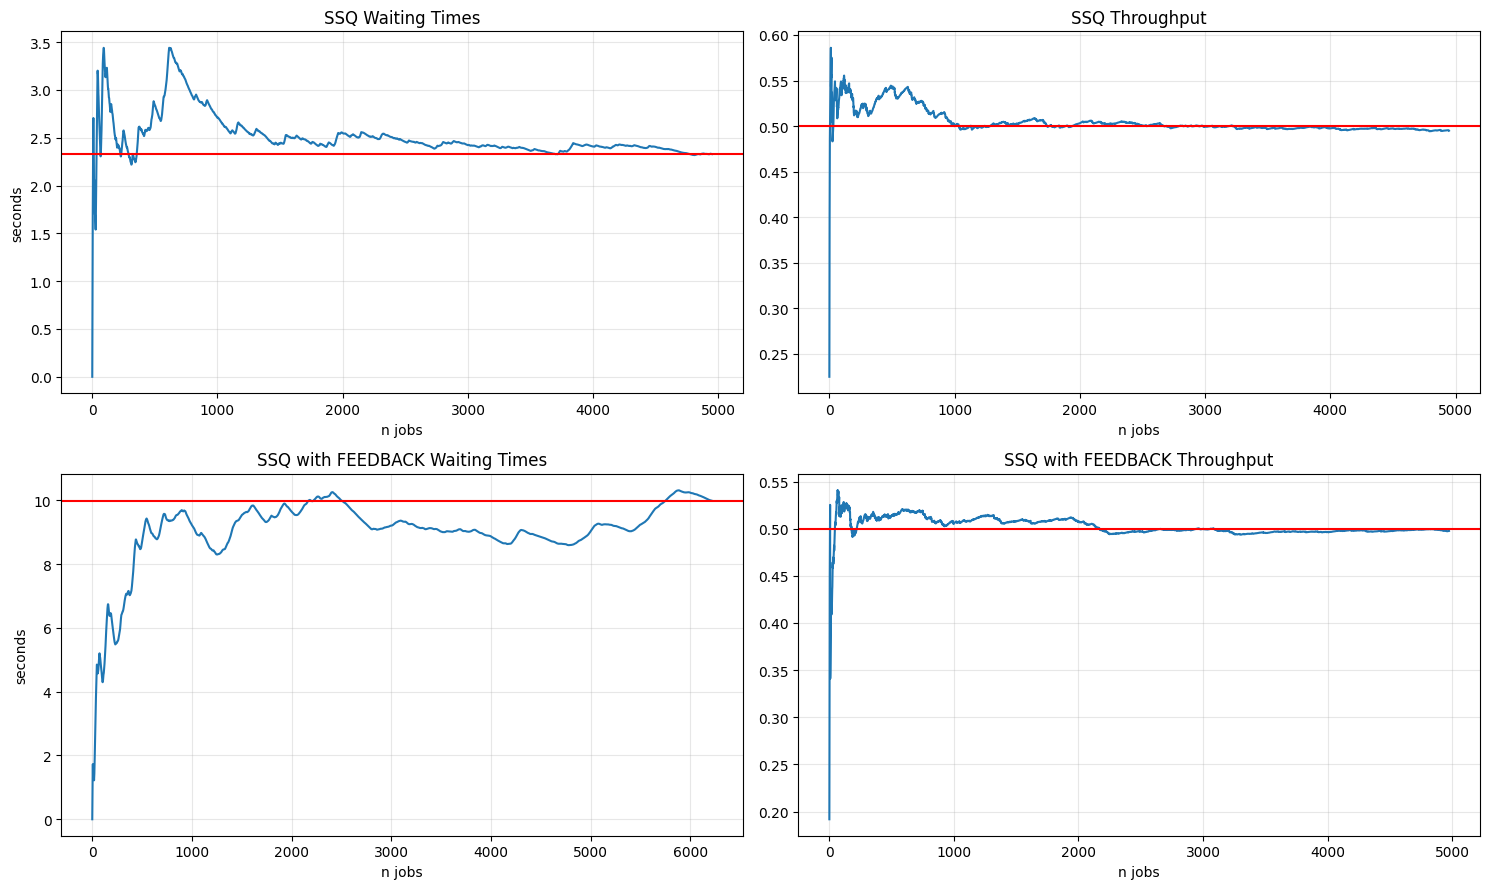

In [60]:
fig = plt.figure(figsize=(15,9))
ax = fig.subplots(nrows=2, ncols=2)

ax[0][0].plot(ssq_avg_waiting_times)
ax[0][0].axhline(ssq_waiting_time_avg, color='red')
ax[0][0].set_ylabel('seconds')
ax[0][0].set_xlabel("n jobs")
#ax[0].set_yticks(np.arange(0,45,2))
#ax[0].set_xticks(np.arange(0,700,50))
ax[0][0].set_title("SSQ Waiting Times")
ax[0][0].grid(alpha=0.3)

ax[1][0].plot(ssq_feedback_avg_waiting_times)
ax[1][0].axhline(ssq_feedback_waiting_time_avg, color='red')
ax[1][0].set_ylabel('seconds')
ax[1][0].set_xlabel("n jobs")
#ax[0].set_yticks(np.arange(0,45,2))
#ax[0].set_xticks(np.arange(0,700,50))
ax[1][0].set_title("SSQ with FEEDBACK Waiting Times")
ax[1][0].grid(alpha=0.3)

ax[0][1].plot(SSQ['throughput'])
ax[0][1].axhline(0.5, color='red')
ax[0][1].set_xlabel("n jobs")
#ax[1].set_yticks(np.arange(0.5,3,0.25))
#ax[1].set_xticks(np.arange(0,700,50))
ax[0][1].set_title("SSQ Throughput")
ax[0][1].grid(alpha=0.3)

ax[1][1].plot(SSQ_FEEDBACK['throughput'])
ax[1][1].axhline(0.5, color='red')
ax[1][1].set_xlabel("n jobs")
#ax[1].set_yticks(np.arange(0.5,3,0.25))
#ax[1].set_xticks(np.arange(0,700,50))
ax[1][1].set_title("SSQ with FEEDBACK Throughput")
ax[1][1].grid(alpha=0.3)

fig.tight_layout()